In [1]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from image_points import *
from read_positions import read_positions
from perspective import *
import random
%matplotlib inline
import random
from helper import *
from layout import *


ModuleNotFoundError: No module named 'visualize'

In [2]:
df = read_positions(label_dir='../../data_all/labels', output_csv='positions.csv')
# df = df[(df['Camera'] == 1) | (df['Camera'] == 2) | (df['Camera'] == 4)]
df.head(11)
len(df)

8090

In [3]:
df_proj = project_df(df)
print(f'LEN = {len(df_proj)}')
df_proj.head()
df_proj['Camera'].value_counts()

/tmp/ipykernel_1767911/780454095.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_proj = pd.concat([df_proj, pd.DataFrame([data])], ignore_index=True)


LEN = 8090


Camera
2    3025
7    2186
1    1382
6     933
4     564
Name: count, dtype: int64

In [4]:
df_proj = remove_duplicate_elephants(df_proj)
df_proj['Camera'].value_counts()

Camera
2    2535
7    2186
1    1382
6     933
4     564
Name: count, dtype: int64

In [5]:
df_proj['Hour'] = df_proj['Date'].dt.hour
def map_to_time_window(hour):
    return f'{int(np.floor(hour / 3) * 3):02d}-{int(np.floor(hour / 3) * 3 + 3):02d}'

# Apply the function to create a time window column
df_proj['Time_Window'] = df_proj['Hour'].apply(map_to_time_window)
df_proj[['Hour', 'Time_Window']]
time_windows = df_proj['Time_Window'].unique().tolist()
time_windows.sort()
for tw in time_windows:
    print(tw, end = " ")
    print(len(df_proj[df_proj['Time_Window'] == tw]))

00-03 1045
03-06 472
06-09 175
09-12 249
12-15 1582
15-18 1328
18-21 1383
21-24 1366


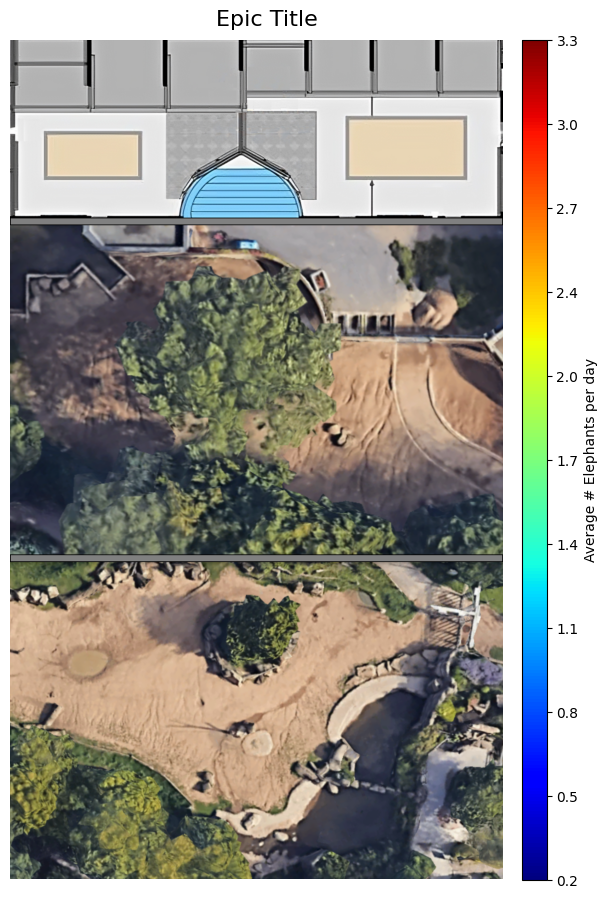

In [8]:
# def add_colorbar(image, min_val, max_val, title=None, show=False):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 10),
#                                    gridspec_kw={'width_ratios': [20, 1], 'wspace': 0.05})
#     if title is not None:
#         fig.suptitle(title, fontsize=16)
        
#     # Display the image in the first subplot
#     ax1.imshow(image[..., ::-1]) 
#     ax1.axis('off')  # Turn off axis for image
    
#     # Create a colormap and normalization instance
#     cmap = mpl.cm.jet
#     norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
    
#     # Create the colorbar in the second subplot
#     cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
#     cb1.set_label('Average # Elephants per day')
#     # Set custom ticks if needed (here just showing min and max)
#     tick_values = np.linspace(min_val, max_val, num=11)
#     cb1.set_ticks(tick_values)
#     cb1.set_ticks(tick_values)
#     # cb1.set_ticklabels([f'{min_val}', f'{max_val}'])
#     cb1.set_ticklabels([f'{val.round(1)}' for val in tick_values])
#     if not show:
#         plt.close()
#     #fig.tight_layout()
#     fig.subplots_adjust(top=0.95)
#     return fig

l = create_layout(cv2.imread('maps/map12.png'), cv2.imread('maps/map4_real.png'), cv2.imread('maps/map6_real.png'), cv2.imread('maps/map7.png'))
fig = add_colorbar(l, 3.3/20, 3.3, 'Epic Title', show=True)
# fig.savefig('x.png', bbox_inches='tight')

# fig.show()


In [11]:
def create_full_heatmap(df, save_path, days_interval=10, min_scale=20, title=None):
    camera_ids = [2, 4, 6, 7]
    raw_heatmaps = []
    heatmap_1 = get_heatmap_new(df, [1,2], CAMERA_to_MAP[1])
    raw_heatmaps.append(heatmap_1)
    for camera in camera_ids[1:]:
        raw_heatmaps.append(get_heatmap_new(df, [camera], CAMERA_to_MAP[camera]))
    global_max = np.max([np.max(heatmap) for heatmap in raw_heatmaps])

    def normalize_and_apply_colormap(heatmap, global_max, min_scale=min_scale):
        # Scale heatmap values based on global_max directly
        heatmap_scaled = (heatmap / global_max) * 255 
        heatmap_scaled = np.clip(heatmap_scaled, 0, 255).astype(np.uint8)  # Ensure values are within byte range
        zero_mask = (heatmap_scaled < 255/min_scale)

        heatmap_color = cv2.applyColorMap(heatmap_scaled, cv2.COLORMAP_JET)
        heatmap_color[zero_mask] = (0,0,0)
        return heatmap_color

    normalized_heatmaps = [normalize_and_apply_colormap(heatmap, global_max) for heatmap in raw_heatmaps]

    
    original_img = cv2.imread(CAMERA_to_PATH[1])
    # plot_images(original_img)
    heatmap_color = normalized_heatmaps[0]
    overlayed_img1 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
    
    original_img = cv2.imread(CAMERA_to_PATH[7])
    heatmap_color = normalized_heatmaps[3]
    overlayed_img7 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
    
    original_img = cv2.imread(CAMERA_to_PATH[6])
    heatmap_color = normalized_heatmaps[2]
    overlayed_img6 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
    
    original_img = cv2.imread(CAMERA_to_PATH[4])
    heatmap_color = normalized_heatmaps[1]
    overlayed_img4 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)

    final_layout = create_layout(overlayed_img1, overlayed_img4, overlayed_img6, overlayed_img7)

    max_per_day = global_max/days_interval
    
    fig = add_colorbar(final_layout, max_per_day/min_scale, max_per_day, title)
    fig.savefig(save_path, bbox_inches='tight')
    
create_full_heatmap(df=df_proj[:], save_path='he.png', days_interval=36)

In [ ]:
for tw in time_windows:
    df = df_proj[df_proj['Time_Window'] == tw]
    create_full_heatmap(df=df, save_path=f'he{tw}.png', title=tw)
    

In [ ]:
image_paths = [f"he{x}.png" for x in time_windows]
images = [cv2.imread(path) for path in image_paths]
rows = [cv2.hconcat(images[i:i+4]) for i in range(0, 8, 4)]
# Vertically concatenate the rows to form the final grid
stacked_image = cv2.vconcat(rows)
plot_images(stacked_image)
cv2.imwrite('he_all.png', stacked_image)

In [1]:
# Optionally, load an actual image to overlay the heatmap on

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

def add_colorbar_image(image, min_val, max_val, title=None, show=False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4),
                                   gridspec_kw={'width_ratios': [20, 1], 'wspace': 0.05})
    if title is not None:
        fig.suptitle(title, fontsize=16)
        
    # Display the image in the first subplot
    ax1.imshow(image[..., ::-1]) 
    ax1.axis('off')  # Turn off axis for image
    
    # Create a colormap and normalization instance
    cmap = mpl.cm.jet
    norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
    
    # Create the colorbar in the second subplot
    cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
    cb1.set_label('Average # Elephants per day')
    # Set custom ticks if needed (here just showing min and max)
    tick_values = np.linspace(min_val, max_val, num=11)
    cb1.set_ticks(tick_values)
    cb1.set_ticks(tick_values)
    # cb1.set_ticklabels([f'{min_val}', f'{max_val}'])
    cb1.set_ticklabels([f'{val.round(1)}' for val in tick_values])
    if not show:
        plt.close()
    #fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    return fig

def one_heatmap(df, camera, min_scale=20):
    heatmap = get_heatmap_new(df, camera, CAMERA_to_MAP[camera])
    global_max = np.max(heatmap)
    heatmap_scaled = (heatmap / global_max) * 255 
    heatmap_scaled = np.clip(heatmap_scaled, 0, 255).astype(np.uint8)  # Ensure values are within byte range
    zero_mask = (heatmap_scaled < 255/min_scale)

    heatmap_color = cv2.applyColorMap(heatmap_scaled, cv2.COLORMAP_JET)
    heatmap_color[zero_mask] = (0,0,0)
    
    original_img = cv2.imread(CAMERA_to_PATH[camera[0]])
    overlayed_img = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
    plt.figure()
    plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
    plt.show()
    return overlayed_img

l = one_heatmap(df_proj, [1,2])
fig = add_colorbar_image(l, 3.3/20, 3.3, 'Epic Title', show=True)

NameError: name 'df_proj' is not defined